# MNIST GPU Deep Learning Benchmark with H2O Deep Water
In reference to [Szilard's Benchmark-DL](https://github.com/szilard/benchm-dl)

![MNIST](images/mnist.png)

In [1]:
import sys, os
import os.path
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
PATH = os.path.expanduser("~/h2o-3/")
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 mins 58 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,1 day
H2O cluster name:,ubuntu
H2O cluster total nodes:,1
H2O cluster free memory:,2.950 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


### Hardware check

In [2]:
!nvidia-smi

Tue Oct 25 22:18:51 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           Off  | 0000:00:03.0     Off |                  N/A |
| N/A   35C    P0    40W / 125W |    131MiB /  4036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Data preparation

In [3]:
train = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")
predictors  = list(range(0,784))
resp        = 784

train[predictors] = train[predictors]/255.0
train[resp] = train[resp].asfactor()
nclasses    = train[resp].nlevels()[0]

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Define the model architecture

In [4]:
def cnn(num_classes):
    import mxnet as mx
    data    = mx.symbol.Variable('data')

    conv1   = mx.symbol.Convolution(data=data, kernel=(4,4), num_filter=32)
    relu1   = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1   = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2   = mx.symbol.Convolution(data=pool1, kernel=(3,3), num_filter=16)
    relu2   = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2   = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
    drop    = mx.symbol.Dropout(data=pool2, p=0.2)

    flatten = mx.symbol.Flatten(data=drop)
    fc1     = mx.symbol.FullyConnected(data=flatten, num_hidden=128)
    relu3   = mx.symbol.Activation(data=fc1, act_type="relu")

    fc2     = mx.symbol.FullyConnected(data=relu3, num_hidden=64)
    relu4   = mx.symbol.Activation(data=fc2, act_type="relu")

    fc3     = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    net     = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return net
cnn(nclasses).save("/tmp/cnn.json")

### Train the model

In [5]:
model = H2ODeepWaterEstimator(
    epochs=10,
    learning_rate=0.05,
    learning_rate_annealing=1e-5,
    momentum_start=0.9,
    momentum_stable=0.9,
    mini_batch_size=128,
    network_definition_file="/tmp/cnn.json",
    image_shape=[28,28],                ## MNIST is 28x28 pixels
    channels=1,                         ## monochrome
    device_id=[0],                      ## select which GPU to use
    gpu=True,                           ## disable to compare to CPU
    standardize=False,                  ## data was manually scaled to 0..1
    ignore_const_cols=False,            ## include all pixels even though some are always 0
    seed=1234                           ## for reproducibility
    #,score_duty_cycle=0                ## uncomment for faster run (no scoring until the end)
)
                              
model.train(x=predictors,y=resp, training_frame=train)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


### Inspect the model

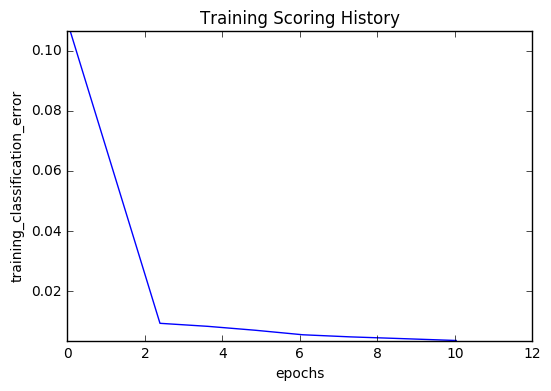

In [6]:
model.plot()

In [7]:
model.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477433511844_3
Status of Deep Learning Model: user, 261.3 KB, predicting C785, 10-class classification, 602,112 training samples, mini-batch size 128



,input_neurons,rate,momentum
,784,0.0071214,0.9




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00338318794608
RMSE: 0.058165178123
LogLoss: 0.0128656748712
Mean Per-Class Error: 0.00360677800463
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
992.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0020121,2 / 994
0.0,1112.0,1.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0053667,"6 / 1,118"
0.0,1.0,966.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0020661,2 / 968
0.0,0.0,0.0,993.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0040120,4 / 997
0.0,1.0,0.0,0.0,991.0,0.0,0.0,0.0,0.0,4.0,0.0050201,5 / 996
0.0,0.0,1.0,0.0,0.0,885.0,1.0,0.0,2.0,0.0,0.0044994,4 / 889
1.0,0.0,0.0,0.0,0.0,0.0,994.0,0.0,1.0,0.0,0.0020080,2 / 996
0.0,0.0,1.0,0.0,2.0,0.0,0.0,996.0,0.0,1.0,0.004,"4 / 1,000"
0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1035.0,1.0,0.0019286,"2 / 1,037"
1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,965.0,0.0051546,5 / 970


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9963874
2,0.9993979
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-25 22:19:11,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-25 22:19:12,2.846 sec,5680 obs/sec,0.0682667,1,4096.0,0.3078531,0.3413933,0.1067737
,2016-10-25 22:19:26,15.825 sec,10615 obs/sec,2.3893333,35,143360.0,0.0886710,0.0315366,0.0093327
,2016-10-25 22:19:32,21.074 sec,11693 obs/sec,3.6181333,53,217088.0,0.0811009,0.0243839,0.0083292
,2016-10-25 22:19:37,26.361 sec,12291 obs/sec,4.8469333,71,290816.0,0.0758482,0.0212225,0.0070246
,2016-10-25 22:19:42,31.638 sec,12681 obs/sec,6.0757333,89,364544.0,0.0684753,0.0181627,0.0055193
,2016-10-25 22:19:47,36.869 sec,12971 obs/sec,7.3045333,107,438272.0,0.0626108,0.0151937,0.0048169
,2016-10-25 22:19:53,42.727 sec,13087 obs/sec,8.4650667,124,507904.0,0.0617362,0.0146889,0.0043151
,2016-10-25 22:20:00,49.337 sec,13311 obs/sec,10.0352,147,602112.0,0.0581652,0.0128657,0.0036126


In [8]:
model.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
0,,2016-10-25 22:19:11,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN
1,,2016-10-25 22:19:12,2.846 sec,5680 obs/sec,0.068267,1,4096.0,0.307853,0.341393,0.106774
2,,2016-10-25 22:19:26,15.825 sec,10615 obs/sec,2.389333,35,143360.0,0.088671,0.031537,0.009333
3,,2016-10-25 22:19:32,21.074 sec,11693 obs/sec,3.618133,53,217088.0,0.081101,0.024384,0.008329
4,,2016-10-25 22:19:37,26.361 sec,12291 obs/sec,4.846933,71,290816.0,0.075848,0.021222,0.007025
5,,2016-10-25 22:19:42,31.638 sec,12681 obs/sec,6.075733,89,364544.0,0.068475,0.018163,0.005519
6,,2016-10-25 22:19:47,36.869 sec,12971 obs/sec,7.304533,107,438272.0,0.062611,0.015194,0.004817
7,,2016-10-25 22:19:53,42.727 sec,13087 obs/sec,8.465067,124,507904.0,0.061736,0.014689,0.004315
8,,2016-10-25 22:20:00,49.337 sec,13311 obs/sec,10.035200,147,602112.0,0.058165,0.012866,0.003613


### Let's evaluate the test set performance

In [9]:
test = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")
test[predictors] = test[predictors]/255.0
test[resp] = test[resp].asfactor()

print(model.model_performance(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsMultinomial: deepwater
** Reported on test data. **

MSE: 0.00631729605284
RMSE: 0.0794814195447
LogLoss: 0.0236156551342
Mean Per-Class Error: 0.00733369768305
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
975.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0051020,5 / 980
0.0,1133.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0017621,"2 / 1,135"
1.0,0.0,1029.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0029070,"3 / 1,032"
0.0,0.0,1.0,1001.0,0.0,4.0,0.0,1.0,2.0,1.0,0.0089109,"9 / 1,010"
0.0,0.0,1.0,0.0,978.0,0.0,1.0,0.0,0.0,2.0,0.0040733,4 / 982
2.0,0.0,0.0,5.0,0.0,882.0,1.0,0.0,0.0,2.0,0.0112108,10 / 892
3.0,2.0,0.0,1.0,2.0,1.0,947.0,0.0,2.0,0.0,0.0114823,11 / 958
0.0,3.0,2.0,0.0,0.0,0.0,0.0,1020.0,2.0,1.0,0.0077821,"8 / 1,028"
0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,966.0,3.0,0.0082136,8 / 974
0.0,1.0,0.0,0.0,5.0,3.0,0.0,3.0,0.0,997.0,0.0118930,"12 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9928
2,0.9988
3,0.9996
4,0.9998000
5,0.9999
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


In [10]:
h2o.download_all_logs("/tmp/")

Writing H2O logs to /tmp/h2ologs_20161025_102032.zip


u'/tmp/h2ologs_20161025_102032.zip'